<a href="https://colab.research.google.com/github/3monochloride4/Bangkit-Capstone-Project-repo/blob/main/ML_model_maxterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
!pip install tensorflowjs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

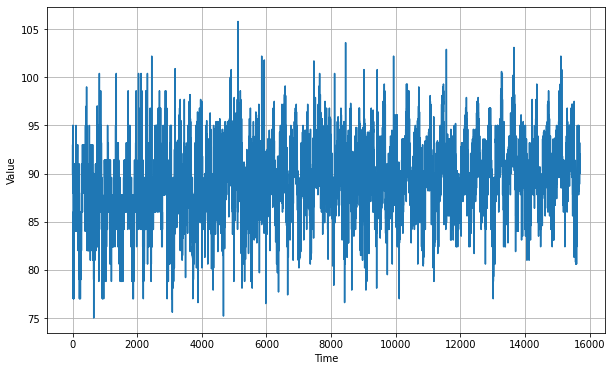

In [ ]:
import csv
i=1
time_step = []
precipitation = []

with open('/tmp/datasetCuacaSmg1957-2021fix.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    precipitation.append(float(row[2]))
    time_step.append(i)
    i+=1

series = np.array(precipitation)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 13000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 100
batch_size = 128
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(13000,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
101/101 [==============================] - 6s 26ms/step - loss: 53.4911 - mae: 53.9911
Epoch 2/100
101/101 [==============================] - 3s 27ms/step - loss: 15.4908 - mae: 15.9786
Epoch 3/100
101/101 [==============================] - 3s 27ms/step - loss: 4.5392 - mae: 4.9954
Epoch 4/100
101/101 [==============================] - 3s 27ms/step - loss: 4.4470 - mae: 4.9026
Epoch 5/100
101/101 [==============================] - 3s 27ms/step - loss: 4.3980 - mae: 4.8536
Epoch 6/100
101/101 [==============================] - 3s 27ms/step - loss: 4.3409 - mae: 4.7963
Epoch 7/100
101/101 [==============================] - 3s 27ms/step - loss: 4.2777 - mae: 4.7327
Epoch 8/100
101/101 [==============================] - 3s 27ms/step - loss: 4.2137 - mae: 4.6685
Epoch 9/100
101/101 [==============================] - 3s 26ms/step - loss: 4.1303 - mae: 4.5846
Epoch 10/100
101/101 [==============================] - 3s 27ms/step - loss: 4.0206 - mae: 4.4737
Epoch 11/100
101/101 [===

(1e-08, 0.0001, 0.0, 20.0)

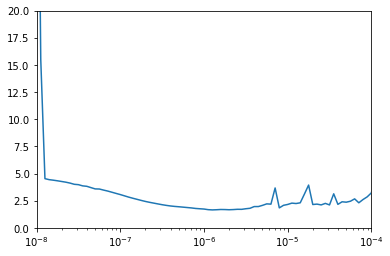

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 20])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", 'accuracy'])
history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
65/65 [==============================] - 5s 29ms/step - loss: 12.6575 - mae: 13.1356 - accuracy: 0.0000e+00
Epoch 2/100
65/65 [==============================] - 2s 29ms/step - loss: 3.9181 - mae: 4.3805 - accuracy: 0.0000e+00
Epoch 3/100
65/65 [==============================] - 2s 30ms/step - loss: 3.3239 - mae: 3.7828 - accuracy: 0.0000e+00
Epoch 4/100
65/65 [==============================] - 2s 29ms/step - loss: 2.9780 - mae: 3.4343 - accuracy: 0.0000e+00
Epoch 5/100
65/65 [==============================] - 2s 31ms/step - loss: 2.7333 - mae: 3.1879 - accuracy: 0.0000e+00
Epoch 6/100
65/65 [==============================] - 2s 30ms/step - loss: 2.4397 - mae: 2.8922 - accuracy: 0.0000e+00
Epoch 7/100
65/65 [==============================] - 2s 31ms/step - loss: 2.2377 - mae: 2.6887 - accuracy: 0.0000e+00
Epoch 8/100
65/65 [==============================] - 2s 30ms/step - loss: 2.1267 - mae: 2.5769 - accuracy: 0.0000e+00
Epoch 9/100
65/65 [==============================] - 2

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], 60)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time-60:-1, -1, 0]
print(rnn_forecast.shape)

(15639, 60, 1)
(2698,)


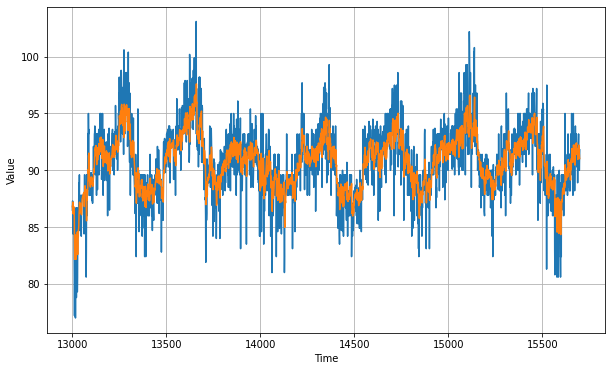

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.5016103

<Figure size 432x288 with 0 Axes>

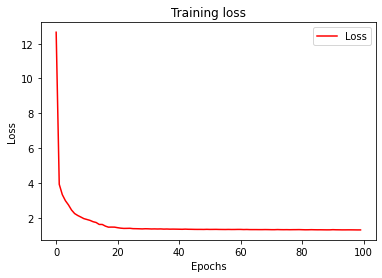

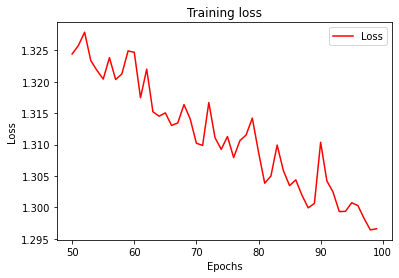

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[50:]
zoomed_epochs = range(50,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast.shape, x_valid.shape)

(2698,) (2698,)


In [ ]:
print(rnn_forecast)

[86.8287   86.71445  87.208435 ... 91.40314  91.11555  91.03273 ]


In [ ]:
import time
saved_model_path = "/tmp/saved_model/{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras {saved_model_path} /tmp/converted_model_maxterm

2021-06-07 12:47:44.449629: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
